In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


### Data Preparation

In [2]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [3]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [4]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.6,random_state=42)
x_dev,x_test,y_dev,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

#train 0.6
#dev 0.2
#test 0.2
#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_dev=scaler_x.transform(x_dev)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_dev=scaler_y.transform(y_dev.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))


### Tests

In [29]:
#fitting model

model_nn = MLPRegressor(hidden_layer_sizes=(16,16,16),
                        max_iter=1000,
                        solver='adam',
                        activation='relu',
                        random_state=42,
                        learning_rate_init=0.001,
                        alpha=0.5,
                        early_stopping=True,
                        tol=1E-9,)

#fit
model_nn.fit(x_train,y_train.ravel())

#get predictions
test_pred=model_nn.predict(x_test)
dev_pred=model_nn.predict(x_dev)
train_pred=model_nn.predict(x_train)

test_mse = mean_squared_error(y_test, test_pred)
dev_mse=mean_squared_error(y_dev,dev_pred)
train_mse=mean_squared_error(y_train,train_pred)

print('train mse: ' +str(train_mse)+'\n'+'dev mse: ' +str(dev_mse)+'\n'+'test mse: '+str(test_mse))


train mse: 0.22076097825116384
dev mse: 0.3561331422975426
test mse: 0.3881132822966682


In [31]:
(test_mse-dev_mse)/dev_mse*100

8.979826980665216

In [18]:
### find smallest overfit difference
param_grid = {
    'alpha': np.logspace(-5, 1, 7),
    'learning_rate_init': np.logspace(-5, -3, 3),
}

#track best model
best_diff = np.inf
best_params = {}

#comb of params
for alpha in param_grid['alpha']:
    
    for learning_rate_init in param_grid['learning_rate_init']:
        
        # Configure and train the model
        
        model = MLPRegressor(hidden_layer_sizes=(16,16,16),
                             max_iter=10000,
                             solver='adam',
                             activation='relu',
                             random_state=42,
                             alpha=alpha,
                             learning_rate_init=learning_rate_init)
        
        model.fit(x_train, y_train.ravel())
        
        # Evaluate on both the training and validation sets
        train_mse = mean_squared_error(y_train, model.predict(x_train))
        dev_mse = mean_squared_error(y_dev, model.predict(x_dev))
        
        # Calculate the absolute difference
        diff = abs(train_mse - dev_mse)
        
        # Update the best model if the current model has a smaller difference
        if diff < best_diff:
            best_diff = diff
            best_params = {'alpha': alpha, 'learning_rate_init': learning_rate_init}

# Output the best parameters and their performance
print(f"Best parameters for minimizing overfitting: {best_params}")
print(f"Smallest MSE difference between training and validation: {best_diff}")


c:\Users\L\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Best parameters for minimizing overfitting: {'alpha': 10.0, 'learning_rate_init': 0.0001}
Smallest MSE difference between training and validation: 0.10071884715189913


Text(0.5, 1.0, "Before 'boruta'")

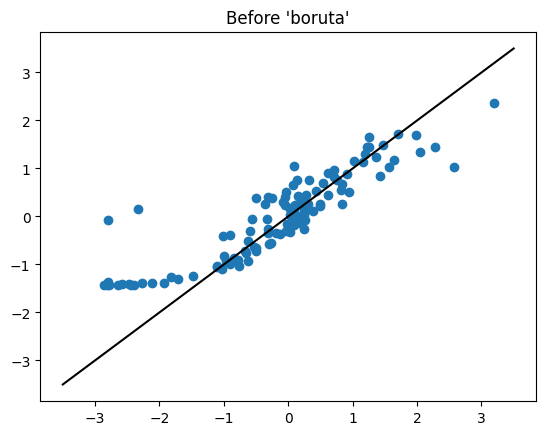

In [117]:
#parity on test set
plt.scatter(y_test, test_pred)
plt.plot([-3.5,3.5],[-3.5,3.5],'black')
plt.title('Before \'boruta\'')

### Importance evaluation Holdout/External validation


In [119]:
def eval_importance_holdout(architecture,fitX,fitY,importanceX,importanceY):
    importance_df=pd.DataFrame()
    
    for structure in architecture:
        
        # Train MLPRegressor
        mlp= MLPRegressor(hidden_layer_sizes=structure,
                          max_iter=10000,
                          solver='adam',
                          activation='tanh',
                          random_state=42)

        mlp.fit(fitX, fitY.ravel())

        # Perform permutation importance
        results = permutation_importance(mlp, importanceX, importanceY, n_repeats=70, random_state=42, n_jobs=4,scoring='neg_mean_squared_error')
        
        # Get the importance of the features
        importance = results.importances_mean
        
        #replace negative values by zero
        importance[importance<0]=0
        
        #norm
        scaler=MinMaxScaler()
        importance=scaler.fit_transform(importance.reshape(-1,1)).flatten()
    
        importance_df['layers'+str(structure)]=importance
    return importance_df

In [120]:
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]
                #eval_importance_holdout(architecture,fitX,fitY,importanceX,importanceY)
importance_holdout=eval_importance_holdout(layers,x_train,y_train,x_train,y_train)

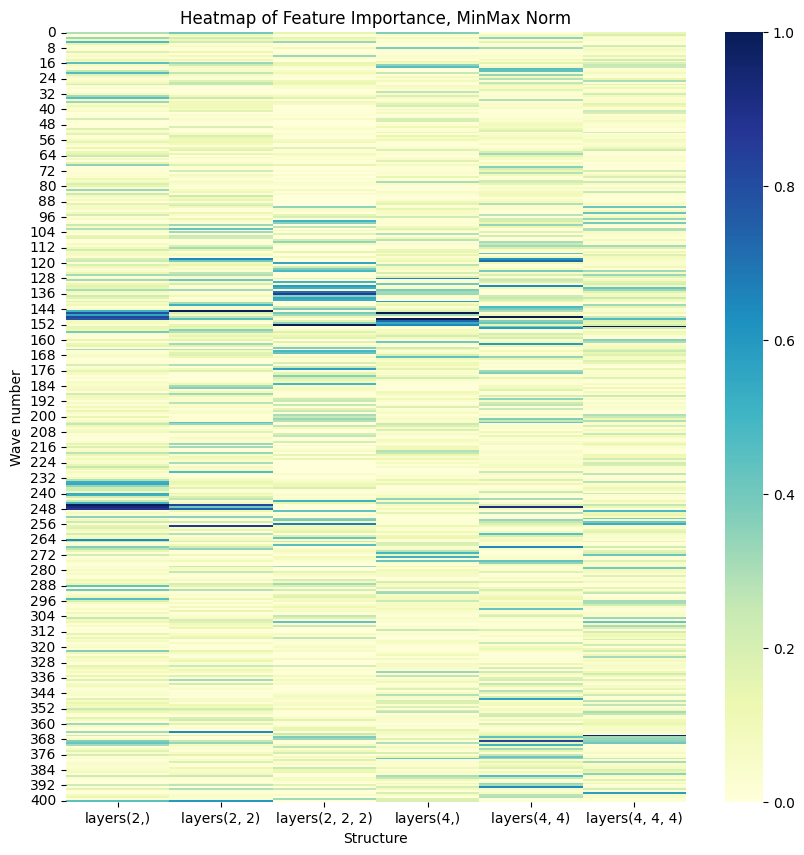

In [121]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_holdout, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance, MinMax Norm')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()


### benchmarking Holdout

In [131]:
def print_long(frame):
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,):
     print(frame)

In [128]:
#turn into function?

#dev MSE for different models with various thresholds(i)

#get some values for different training
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored = pd.DataFrame()

x_train=pd.DataFrame(x_train)
x_dev=pd.DataFrame(x_dev)
x_test=pd.DataFrame(x_test)

for structure in layers:
    
    for i in np.arange(0,0.1,0.005):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_holdout.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train[columns_to_keep]
        x_dev_important=x_dev[columns_to_keep]
        
        #get predictions
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=10000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train.ravel())
        
        dev_pred_important=model_nn.predict(x_dev_important)
        dev_mse_i = mean_squared_error(y_dev, dev_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = dev_mse_i

In [ ]:
stored

In [141]:
# all sets mse for different tresholds

columns=['threshold','train mse','dev mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)


for i in np.arange(0,0.3,0.01):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_holdout.T.loc['layers'+str((2,2)),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train[columns_to_keep]
    x_dev_important=x_dev[columns_to_keep]
    x_test_important=x_test[columns_to_keep]
    
    #get predictions
    model_nn= MLPRegressor(hidden_layer_sizes=(2,2),
                           max_iter=10000,
                           solver='adam',
                           activation='tanh',
                           random_state=42)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    dev_pred_important=model_nn.predict(x_dev_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train,train_pred_important)
    dev_mse_i=mean_squared_error(y_dev,dev_pred_important)
    test_mse_i = mean_squared_error(y_test, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,dev_mse_i,test_mse_i,num_features]

In [142]:
stored_2

,threshold,train mse,dev mse,test mse,wavelengths included
0.00,0.00,0.097676,0.178263,0.195599,401.0
0.01,0.01,0.118749,0.246217,0.253227,323.0
0.02,0.02,0.140637,0.245326,0.267109,289.0
0.03,0.03,0.195772,0.349271,0.369281,260.0
0.04,0.04,0.091978,0.198453,0.204003,237.0
0.05,0.05,0.210074,0.372068,0.396116,217.0
0.06,0.06,0.103458,0.202112,0.220290,195.0
0.07,0.07,0.131930,0.252752,0.293681,182.0
0.08,0.08,0.097869,0.190971,0.204574,169.0
0.09,0.09,0.087641,0.184774,0.200499,159.0


### benchmarking Cross

In [48]:
#data split and normalisation
x_train_cv,x_test_cv,y_train_cv,y_test_cv=train_test_split(X,Y,test_size=0.8,random_state=42)

#train 0.8
#test 0.2



In [49]:

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train_cv)
x_train_cv=scaler_x.transform(x_train_cv)
x_test_cv=scaler_x.transform(x_test_cv)

scaler_y=StandardScaler()
scaler_y.fit(y_train_cv.values.reshape(-1,1))
y_train_cv=scaler_y.transform(y_train_cv.values.reshape(-1,1))
y_test_cv=scaler_y.transform(y_test_cv.values.reshape(-1,1))

In [51]:
#evaluate importance in each fold then take mean
layers = [(2,)]

importance_df_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)

x_train_cv=pd.DataFrame(x_train_cv)

for structure in layers:
    
    fold_importance=np.zeros((x_train_cv.shape[1],kf.n_splits))
    
    for fold, (train_index, test_index) in enumerate(kf.split(x_train_cv)):
        
        
        x_train_fold=x_train_cv.iloc[train_index]
        x_val_fold=x_train_cv.iloc[test_index]
        y_train_fold=y_train_cv[train_index]
        y_val_fold=y_train_cv[test_index]
        
        #modelo
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=10000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)
        
        model_nn.fit(x_train_fold,y_train_fold.ravel())
        #permutation importance
        results=permutation_importance(model_nn,x_val_fold,y_val_fold,n_repeats=10,random_state=42, n_jobs=4)
        
        fold_importance[:,fold]=results.importances_mean
        
    #get average among kfolds
    mean_importance=fold_importance.mean(axis=1)
    
    #zero out neg values
    #mean_importance[mean_importance<0]=0
    
    #norm
    #scaler=MinMaxScaler()
    #norm_importance=scaler.fit_transform(mean_importance.reshape(-1,1)).flatten()
    
    #store to frame
    importance_df_cross['layers'+str(structure)]=mean_importance
    

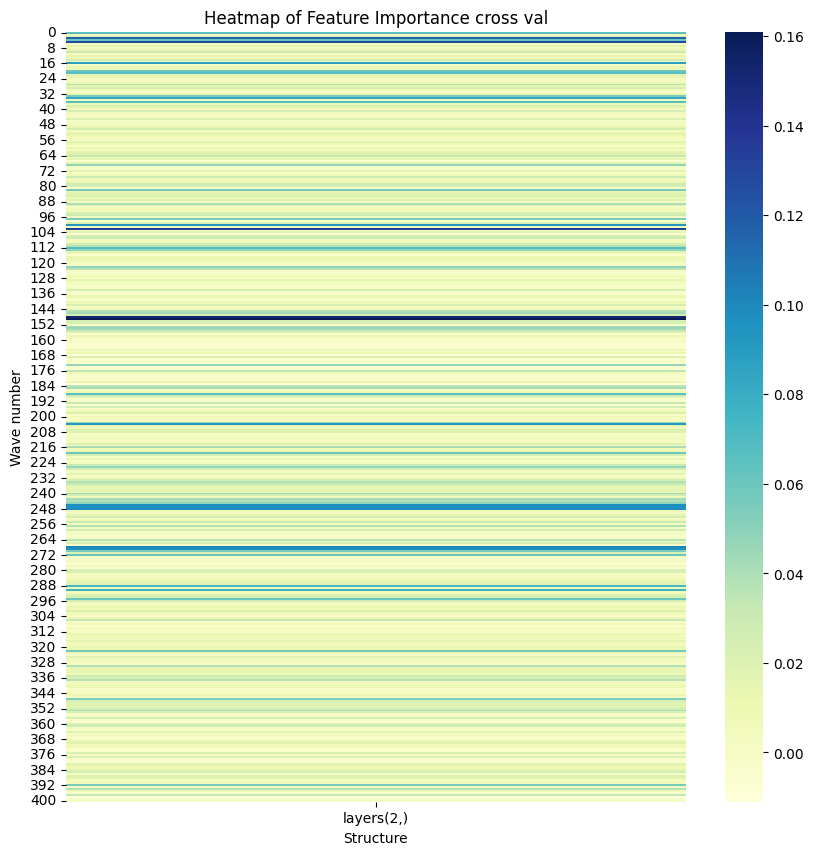

In [52]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_df_cross, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance cross val')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()

In [196]:
#turn into function?

#dev MSE for different models with various thresholds(i) CROSS

#get some values for different training
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored = pd.DataFrame()

x_train_cv=pd.DataFrame(x_train_cv)

for structure in layers:
    
    for i in np.arange(0,0.1,0.005):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_df_cross.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train_cv[columns_to_keep]
        
        #get predictions
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=10000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train_cv.ravel())
        
        train_pred_important=model_nn.predict(x_train_important)
        train_mse_i = mean_squared_error(y_train_cv, train_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = train_mse_i

In [197]:
stored

,"layers(2,)","layers(2, 2)","layers(2, 2, 2)","layers(4,)","layers(4, 4)","layers(4, 4, 4)"
0.000,0.263141,0.277322,0.293774,0.262322,0.262368,0.262985
0.005,0.252681,0.260570,0.275060,0.261751,0.267731,0.266611
0.010,0.272561,0.281911,0.263544,0.265965,0.255135,0.269921
0.015,0.275120,0.275914,0.274365,0.293681,0.266870,0.265324
0.020,0.272432,0.286541,0.269784,0.258993,0.265831,0.266467
0.025,0.267129,0.272734,0.270782,0.251050,0.262290,0.267772
0.030,0.280525,0.266190,0.290718,0.253685,0.263578,0.264541
0.035,0.282246,0.259464,0.269514,0.255544,0.264913,0.257250
0.040,0.254366,0.255691,0.285101,0.258248,0.275872,0.273152
0.045,0.270644,0.259224,0.286535,0.254259,0.269284,0.291514


In [184]:
# all sets mse for different tresholds

columns=['threshold','train mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)


for i in np.arange(0,1.0,0.1):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_df_cross.T.loc['layers'+str((2,)),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train_cv[columns_to_keep]
    x_test_important=x_test_cv[columns_to_keep]
    
    #get predictions
    model_nn= MLPRegressor(hidden_layer_sizes=(2,),
                           max_iter=10000,
                           solver='adam',
                           activation='tanh',
                           random_state=42)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train_cv.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train_cv,train_pred_important)
    test_mse_i = mean_squared_error(y_test_cv, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,test_mse_i,num_features]

In [185]:
stored_2

,threshold,train mse,test mse,wavelengths included
0.0,0.0,0.263141,0.284717,401.0
0.1,0.1,0.273336,0.290438,53.0
0.2,0.2,0.269599,0.287571,20.0
0.3,0.3,0.288593,0.303320,14.0
0.4,0.4,0.282179,0.297774,9.0
0.5,0.5,0.275347,0.292644,8.0
0.6,0.6,0.261454,0.285533,4.0
0.7,0.7,0.261454,0.285533,4.0
0.8,0.8,0.293233,0.306912,3.0
0.9,0.9,0.270607,0.290896,2.0


In [63]:
#cross to evaluate importance and cross validation with important features
#this manner sort of dilutes the results and i can't find the better model...
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)



for structure in layers:
    
    for i in np.arange(0,0.9,0.15):
        
        fold_scores=np.empty(5)
    
        for fold, (train_index,test_index) in enumerate(kf.split(X)):
            
            x_train_fold,x_val_fold=X.iloc[train_index],X.iloc[test_index]
            y_train_fold,y_val_fold=Y[train_index],Y[test_index]

            #get indexing of only features with importance over i over layer 'structure'
            importance=importance_df_cross.T.loc['layers'+str(structure),:]
            mask=importance>=i
            
            #slice of important features
            columns_to_keep=mask[mask].index
            x_train_important=x_train_fold[columns_to_keep]
            x_val_important=x_val_fold[columns_to_keep]
            
            #get predictions
            model_nn=MLPRegressor(hidden_layer_sizes=structure,
                                max_iter=10000,
                                random_state=42,)

            #fit pred and mean squared error
            
            model_nn.fit(x_train_important,y_train_fold.ravel())
            
            val_pred_important=model_nn.predict(x_val_important)
            
            test_mse_i = mean_squared_error(y_val_fold, val_pred_important)
            
            fold_scores[fold]=test_mse_i
            
            
        #store
        stored_cross.loc[i,'layers'+str(structure)] = fold_scores.mean()